In [19]:
# Cell 1: Imports and Load Data (Corrected Path and Timestamp Logic, Add Strategy Params)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import glob 
import re 

# --- Configuration ---
current_notebook_dir = Path.cwd() 
LOGS_PARENT_DIR = current_notebook_dir.parent / "logs"
print(f"Calculated LOGS_PARENT_DIR: {LOGS_PARENT_DIR.resolve()}")

MODEL_TYPE_LOG_SUBDIR_NAME = "backtest_random_forest_calibrated_v2_15m_offset" 
print(f"Expecting detailed logs in subdir: {MODEL_TYPE_LOG_SUBDIR_NAME}")

# --- STRATEGY PARAMETERS (Manually set to match the backtest run being analyzed) ---
# These were the values used in your backtest_classifier_v1.py for the RF Calibrated V2 run
# (as per your log "Strategy Params: MinProb=0.7, Edge=0.15")
# Or, if you used different values, update them here.
# The values from your previous provided log were: MinProb=0.60, Edge=0.10
# The values from your more recent successful run log were: MinProb=0.8, Edge=0.2 (from live_backtest_main.py)
# Let's assume the ones from the successful run that generated the BUY_YES trades:
# MinProb=0.55, Edge=0.05 (as suggested to try)
# If the logs you are analyzing were with MinProb=0.6, Edge=0.1, use those:
STRATEGY_MIN_MODEL_PROB_FOR_CONSIDERATION = 0.60
STRATEGY_EDGE_THRESHOLD_FOR_TRADE = 0.10
print(f"Using for EDA: STRATEGY_MIN_MODEL_PROB_FOR_CONSIDERATION = {STRATEGY_MIN_MODEL_PROB_FOR_CONSIDERATION}")
print(f"Using for EDA: STRATEGY_EDGE_THRESHOLD_FOR_TRADE = {STRATEGY_EDGE_THRESHOLD_FOR_TRADE}")


# --- Load Main Aggregated Trades File ---
all_trades_files_pattern = "ALL_TRADES_WITH_EVALS_random_forest_*.csv" 
all_trades_files = sorted(LOGS_PARENT_DIR.glob(all_trades_files_pattern), key=os.path.getctime, reverse=True)

df_all_decisions = pd.DataFrame()
ALL_TRADES_CSV_PATH = None
run_ts_from_filename = None 

if not all_trades_files:
    print(f"ERROR: No '{all_trades_files_pattern}' file found in {LOGS_PARENT_DIR.resolve()}")
else:
    ALL_TRADES_CSV_PATH = all_trades_files[0] 
    if ALL_TRADES_CSV_PATH:
        print(f"Loading main decision log: {ALL_TRADES_CSV_PATH}")
        try:
            df_all_decisions = pd.read_csv(ALL_TRADES_CSV_PATH)
            df_all_decisions['decision_timestamp_utc'] = pd.to_datetime(df_all_decisions['decision_timestamp_utc'])
            print(f"Loaded {len(df_all_decisions)} total decision records from main log.")

            filename_stem = Path(ALL_TRADES_CSV_PATH).stem
            match_ts = re.search(r'(\d{8}_\d{6})', filename_stem) 
            if match_ts:
                run_ts_from_filename = match_ts.group(1)
            else:
                parts = filename_stem.split('_')
                if parts and len(parts[-1]) >= 15 and parts[-1][:8].isdigit() and parts[-1][9:].isdigit(): # Check for YYYYMMDD_HHMMSS
                    run_ts_from_filename = parts[-1]
                elif parts and len(parts[-1]) == 6 and parts[-1].isdigit(): # Fallback for just HHMMSS (less ideal)
                    print(f"WARNING: Only HHMMSS timestamp found in '{filename_stem}'. Full timestamp needed for best matching.")
                    run_ts_from_filename = parts[-1] 
                # *** IF AUTOMATIC PARSING FAILS, MANUALLY SET THE TIMESTAMP OF YOUR LOGS HERE ***
                # run_ts_from_filename = "20250521_170924" # Example: replace with your actual log timestamp
                # print(f"Using MANUAL OVERRIDE for run_ts_from_filename: {run_ts_from_filename}")


        except Exception as e:
            print(f"Error loading {ALL_TRADES_CSV_PATH}: {e}")
            df_all_decisions = pd.DataFrame()
    else:
        print(f"ERROR: Could not determine a suitable 'ALL_TRADES_WITH_EVALS_random_forest_*.csv' file.")


# --- Load and Merge Detailed Decision Evaluation Logs ---
df_eval_details = pd.DataFrame()
if not df_all_decisions.empty and run_ts_from_filename and len(run_ts_from_filename) == 15 : 
    print(f"Using run_timestamp '{run_ts_from_filename}' for finding decision_eval_logs.")
    decision_eval_log_specific_dir = LOGS_PARENT_DIR / MODEL_TYPE_LOG_SUBDIR_NAME
    eval_log_pattern = f"decision_eval_log_*_random_forest_{run_ts_from_filename}.csv"
    
    print(f"Looking for decision_eval_log files in: {decision_eval_log_specific_dir.resolve()}")
    print(f"Using pattern: {eval_log_pattern}")
    
    decision_eval_files = sorted(list(decision_eval_log_specific_dir.glob(eval_log_pattern)))

    if not decision_eval_files:
        print(f"WARNING: No '{eval_log_pattern}' files found in {decision_eval_log_specific_dir.resolve()}")
    else:
        print(f"Found {len(decision_eval_files)} decision_eval_log files to merge.")
        df_list = []
        for f_path in decision_eval_files:
            try:
                df_temp = pd.read_csv(f_path)
                df_list.append(df_temp)
            except Exception as e:
                print(f"Error loading {f_path}: {e}")
        if df_list:
            df_eval_details = pd.concat(df_list, ignore_index=True)
            df_eval_details['decision_dt_utc'] = pd.to_datetime(df_eval_details['decision_dt_utc'])
            print(f"Loaded and combined {len(df_eval_details)} records from decision_eval_logs.")
            
            df_all_decisions = pd.merge(
                df_all_decisions,
                df_eval_details[['decision_dt_utc', 'market_ticker', 'implied_proba_yes_at_ask', 'edge_for_yes', 'predicted_proba_no', 'implied_proba_no_at_bid', 'edge_for_no', 'considered_action']],
                left_on=['decision_timestamp_utc', 'market_ticker'],
                right_on=['decision_dt_utc', 'market_ticker'],
                how='left',
                suffixes=('', '_eval') 
            )
            if 'decision_dt_utc_eval' in df_all_decisions.columns: 
                 df_all_decisions.drop(columns=['decision_dt_utc_eval'], inplace=True)
            elif 'decision_dt_utc' in df_all_decisions.columns and df_all_decisions.columns.tolist().count('decision_dt_utc') > 1: 
                 df_all_decisions = df_all_decisions.loc[:,~df_all_decisions.columns.duplicated(keep='first')]

            if 'considered_action_eval' in df_all_decisions.columns:
                df_all_decisions['considered_action'] = df_all_decisions['considered_action_eval']
                df_all_decisions.drop(columns=['considered_action_eval'], inplace=True)
                
            print(f"Merged df_eval_details (edge info) into df_all_decisions. New shape: {df_all_decisions.shape}")
            newly_added_cols_from_eval = ['implied_proba_yes_at_ask', 'edge_for_yes', 'predicted_proba_no', 'implied_proba_no_at_bid', 'edge_for_no', 'considered_action']
            for col in newly_added_cols_from_eval:
                if col not in df_all_decisions.columns:
                    print(f"WARNING: Column '{col}' not found after merge.")
                else:
                    print(f"Column '{col}' merged. Non-NaN count: {df_all_decisions[col].notna().sum()}")
        else:
            print("No data loaded from decision_eval_logs, df_eval_details is empty.")
elif not df_all_decisions.empty:
    print("WARNING: run_ts_from_filename issue ('{run_ts_from_filename}'). Skipping merge of detailed eval logs.")


if not df_all_decisions.empty:
    print(f"\nShape of df_all_decisions after potential merge: {df_all_decisions.shape}")
    df_all_decisions.info(verbose=True, show_counts=True)
    print(df_all_decisions.head().to_string()) # Use to_string for wider output

    df_executed_trades = df_all_decisions[
        (df_all_decisions['num_contracts_sim'] > 0) &
        (df_all_decisions['executed_trade_action'].isin(['BUY_YES', 'BUY_NO']))
    ].copy()
    print(f"\nNumber of actual executed trades: {len(df_executed_trades)}")
    if not df_executed_trades.empty:
        print("Sample of executed trades:")
        cols_to_show = ['decision_timestamp_utc', 'market_ticker', 'predicted_proba_yes', 
                        'executed_trade_action', 'num_contracts_sim', 'simulated_entry_price_cents', 
                        'pnl_cents', 'actual_market_result', 'edge_for_yes', 'edge_for_no', 'considered_action']
        existing_cols_to_show = [col for col in cols_to_show if col in df_executed_trades.columns]
        print(df_executed_trades[existing_cols_to_show].head().to_string())
else:
    print("df_all_decisions is empty. Cannot proceed with EDA.")

plt.style.use('seaborn-v0_8-whitegrid')

Calculated LOGS_PARENT_DIR: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/logs
Expecting detailed logs in subdir: backtest_random_forest_calibrated_v2_15m_offset
Using for EDA: STRATEGY_MIN_MODEL_PROB_FOR_CONSIDERATION = 0.6
Using for EDA: STRATEGY_EDGE_THRESHOLD_FOR_TRADE = 0.1
Loading main decision log: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/logs/ALL_TRADES_WITH_EVALS_random_forest_20250521_170924.csv
Loaded 29074 total decision records from main log.
Using run_timestamp '20250521_170924' for finding decision_eval_logs.
Looking for decision_eval_log files in: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/logs/backtest_random_forest_calibrated_v2_15m_offset
Using pattern: decision_eval_log_*_random_forest_20250521_170924.csv
Found 16 decision_eval_log files to merge.
Loaded and combined 29074 records from decision_eval_logs.
Merged df_eval_details (edge info) into df_all_decisions. New shape: (29074, 20)
Column 'implied_proba_yes_at_ask' merged.

--- Overall Backtest Performance ---
Total P&L: $-475.98
Total Executed Trades: 283
Total Contracts Traded: 1371
Average P&L per Trade: $-1.68
Average P&L per Contract: $-0.3472

P&L by Trade Action:
executed_trade_action
BUY_YES   -475.98
Name: pnl_cents, dtype: float64

Overall Win Rate (Executed Trades): 8.13%

Win Rate by Trade Action:
executed_trade_action
BUY_YES    0.081272
Name: is_win, dtype: float64


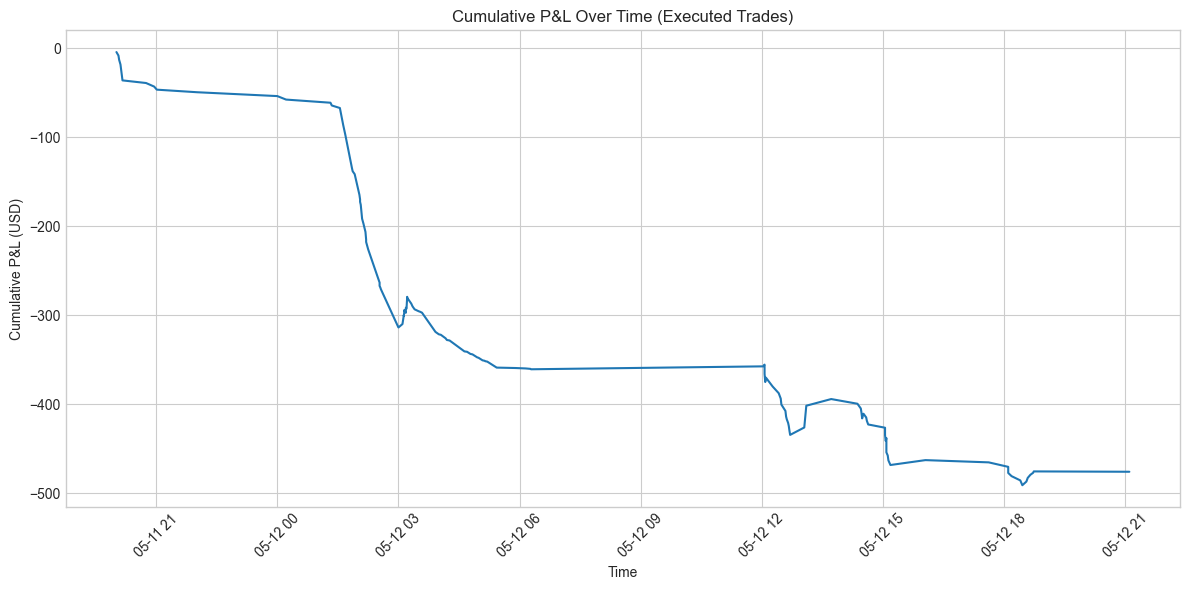

In [20]:
# Cell 2: Overall Performance Summary

if not df_all_decisions.empty and not df_executed_trades.empty:
    total_pnl = df_executed_trades['pnl_cents'].sum() / 100
    total_contracts = df_executed_trades['num_contracts_sim'].sum()
    num_trades = len(df_executed_trades)

    print(f"--- Overall Backtest Performance ---")
    print(f"Total P&L: ${total_pnl:.2f}")
    print(f"Total Executed Trades: {num_trades}")
    print(f"Total Contracts Traded: {total_contracts}")
    if num_trades > 0:
        print(f"Average P&L per Trade: ${total_pnl / num_trades:.2f}")
    if total_contracts > 0:
        print(f"Average P&L per Contract: ${total_pnl / total_contracts:.4f}")

    # P&L by Trade Action
    pnl_by_action = df_executed_trades.groupby('executed_trade_action')['pnl_cents'].sum() / 100
    print("\nP&L by Trade Action:")
    print(pnl_by_action)

    # Win/Loss Analysis
    df_executed_trades['is_win'] = np.where(df_executed_trades['pnl_cents'] > 0, 1, 0)
    win_rate = df_executed_trades['is_win'].mean()
    print(f"\nOverall Win Rate (Executed Trades): {win_rate:.2%}")

    win_rate_by_action = df_executed_trades.groupby('executed_trade_action')['is_win'].mean()
    print("\nWin Rate by Trade Action:")
    print(win_rate_by_action)
    
    # Cumulative P&L Plot
    if 'decision_timestamp_utc' in df_executed_trades.columns:
        df_executed_trades_sorted = df_executed_trades.sort_values(by='decision_timestamp_utc')
        df_executed_trades_sorted['cumulative_pnl_usd'] = df_executed_trades_sorted['pnl_cents'].cumsum() / 100
        
        plt.figure(figsize=(12, 6))
        plt.plot(df_executed_trades_sorted['decision_timestamp_utc'], df_executed_trades_sorted['cumulative_pnl_usd'])
        plt.title('Cumulative P&L Over Time (Executed Trades)')
        plt.xlabel('Time')
        plt.ylabel('Cumulative P&L (USD)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping cumulative P&L plot as 'decision_timestamp_utc' is missing or trades are empty.")
else:
    print("No executed trades to analyze for overall performance.")

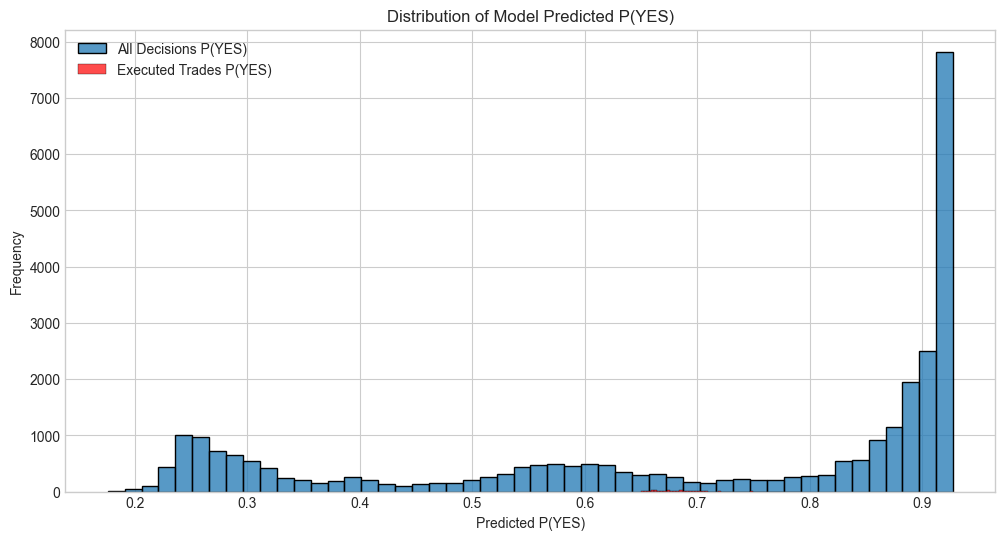


Descriptive statistics for predicted_proba_yes (All Decisions):
count    29074.000000
mean         0.700263
std          0.250149
min          0.175900
25%          0.519125
50%          0.846650
75%          0.916100
max          0.927500
Name: predicted_proba_yes, dtype: float64

Descriptive statistics for predicted_proba_yes (Executed Trades):
count    283.000000
mean       0.676533
std        0.019670
min        0.650000
25%        0.662600
50%        0.674200
75%        0.685250
max        0.792000
Name: predicted_proba_yes, dtype: float64


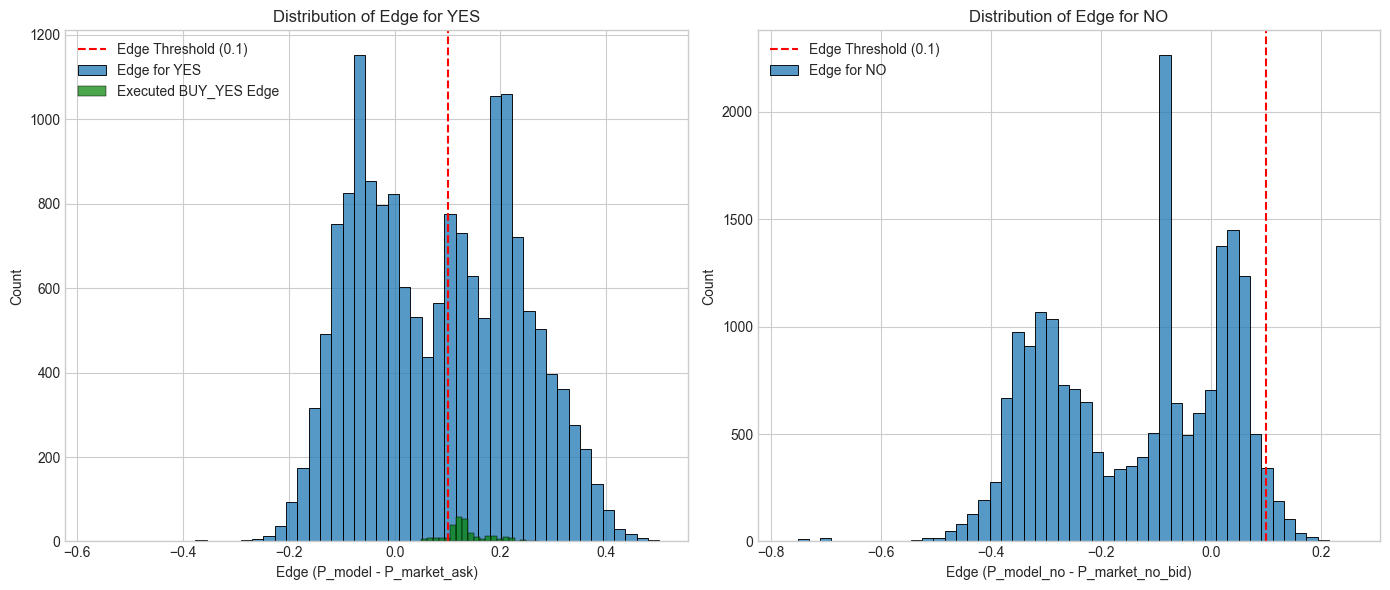


Descriptive statistics for edge_for_yes (All Decisions):
count    16563.000000
mean         0.083124
std          0.148697
min         -0.569100
25%         -0.049400
50%          0.088000
75%          0.205000
max          0.500100
Name: edge_for_yes, dtype: float64

Descriptive statistics for edge_for_no (All Decisions):
count    19825.00000
mean        -0.13679
std          0.16061
min         -0.77220
25%         -0.29050
50%         -0.09260
75%          0.01640
max          0.25640
Name: edge_for_no, dtype: float64

Descriptive statistics for edge_for_yes (Executed BUY_YES Trades):
count    283.000000
mean       0.137098
std        0.041016
min        0.050400
25%        0.114350
50%        0.128000
75%        0.152000
max        0.270600
Name: edge_for_yes, dtype: float64

No BUY_NO trades executed to describe edge for.


In [21]:
# Cell 3: Analysis of Model Probabilities and Edge

if not df_all_decisions.empty:
    plt.figure(figsize=(12, 6))
    sns.histplot(df_all_decisions['predicted_proba_yes'].dropna(), bins=50, kde=False, label='All Decisions P(YES)')
    if not df_executed_trades.empty:
        sns.histplot(df_executed_trades['predicted_proba_yes'].dropna(), bins=50, kde=False, color='red', alpha=0.7, label='Executed Trades P(YES)')
    plt.title('Distribution of Model Predicted P(YES)')
    plt.xlabel('Predicted P(YES)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    print("\nDescriptive statistics for predicted_proba_yes (All Decisions):")
    print(df_all_decisions['predicted_proba_yes'].describe())
    
    if not df_executed_trades.empty:
        print("\nDescriptive statistics for predicted_proba_yes (Executed Trades):")
        print(df_executed_trades['predicted_proba_yes'].describe())

    edge_cols_exist = all(col in df_all_decisions.columns for col in ['edge_for_yes', 'edge_for_no'])
    if edge_cols_exist:
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(df_all_decisions['edge_for_yes'].dropna(), bins=50, kde=False, label='Edge for YES')
        if not df_executed_trades.empty and not df_executed_trades[df_executed_trades['executed_trade_action'] == 'BUY_YES'].empty: # Check if df is not empty
             sns.histplot(df_executed_trades[df_executed_trades['executed_trade_action'] == 'BUY_YES']['edge_for_yes'].dropna(), 
                          bins=20, kde=False, color='green', alpha=0.7, label='Executed BUY_YES Edge')
        plt.title('Distribution of Edge for YES')
        plt.xlabel('Edge (P_model - P_market_ask)')
        # Use the variable defined in Cell 1
        plt.axvline(STRATEGY_EDGE_THRESHOLD_FOR_TRADE, color='r', linestyle='--', label=f'Edge Threshold ({STRATEGY_EDGE_THRESHOLD_FOR_TRADE})')
        plt.legend()

        plt.subplot(1, 2, 2)
        sns.histplot(df_all_decisions['edge_for_no'].dropna(), bins=50, kde=False, label='Edge for NO')
        if not df_executed_trades.empty and not df_executed_trades[df_executed_trades['executed_trade_action'] == 'BUY_NO'].empty: # Check if df is not empty
            sns.histplot(df_executed_trades[df_executed_trades['executed_trade_action'] == 'BUY_NO']['edge_for_no'].dropna(), 
                         bins=20, kde=False, color='orange', alpha=0.7, label='Executed BUY_NO Edge')
        plt.title('Distribution of Edge for NO')
        plt.xlabel('Edge (P_model_no - P_market_no_bid)')
        # Use the variable defined in Cell 1
        plt.axvline(STRATEGY_EDGE_THRESHOLD_FOR_TRADE, color='r', linestyle='--', label=f'Edge Threshold ({STRATEGY_EDGE_THRESHOLD_FOR_TRADE})')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

        print("\nDescriptive statistics for edge_for_yes (All Decisions):")
        print(df_all_decisions['edge_for_yes'].describe())
        print("\nDescriptive statistics for edge_for_no (All Decisions):")
        print(df_all_decisions['edge_for_no'].describe())
        
        if not df_executed_trades.empty:
            if not df_executed_trades[df_executed_trades['executed_trade_action'] == 'BUY_YES'].empty:
                print("\nDescriptive statistics for edge_for_yes (Executed BUY_YES Trades):")
                print(df_executed_trades[df_executed_trades['executed_trade_action'] == 'BUY_YES']['edge_for_yes'].describe())
            else:
                print("\nNo BUY_YES trades executed to describe edge for.")
            
            if not df_executed_trades[df_executed_trades['executed_trade_action'] == 'BUY_NO'].empty:
                print("\nDescriptive statistics for edge_for_no (Executed BUY_NO Trades):")
                print(df_executed_trades[df_executed_trades['executed_trade_action'] == 'BUY_NO']['edge_for_no'].describe())
            else:
                print("\nNo BUY_NO trades executed to describe edge for.")
            
    else:
        print("\nEdge columns ('edge_for_yes', 'edge_for_no') not found in df_all_decisions. Ensure decision_eval_logs were merged correctly in Cell 1.")

else:
    print("No data in df_all_decisions for probability/edge analysis.")


--- Analysis of Non-Executed Decisions ---

Breakdown of 'considered_action' (from detailed eval logs):
considered_action
NO_TRADE_THRESHOLD_NOT_MET    97.815918
NO_TRADE_SIZE_ZERO             1.210704
BUY_YES                        0.973378
Name: proportion, dtype: float64

Breakdown of 'executed_trade_action' (final outcome in main log):
executed_trade_action
NO_TRADE_THRESHOLD_NOT_MET    97.815918
NO_TRADE_SIZE_ZERO             1.210704
BUY_YES                        0.973378
Name: proportion, dtype: float64

--- Analysis of Executed Trades ---


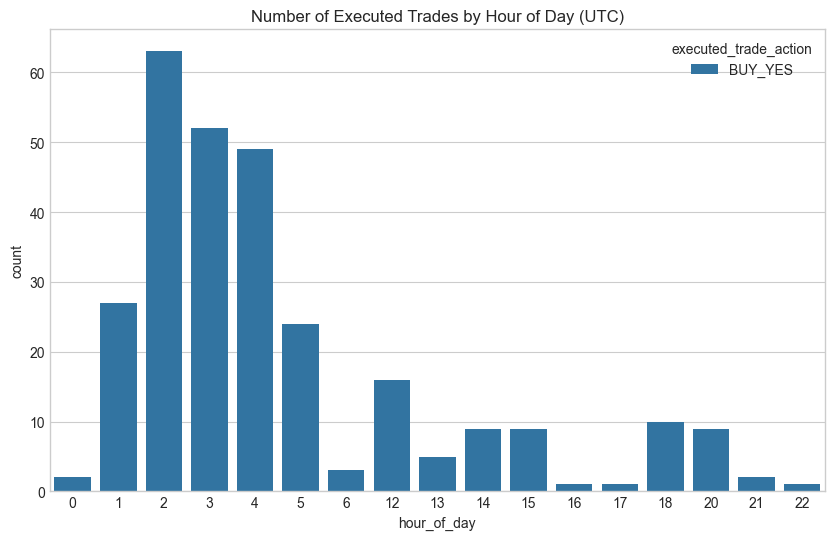

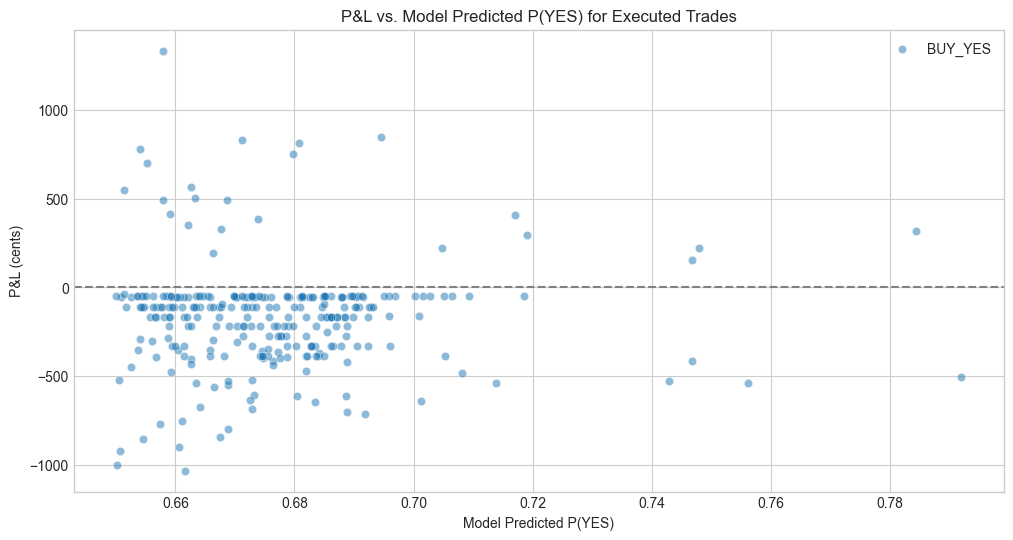

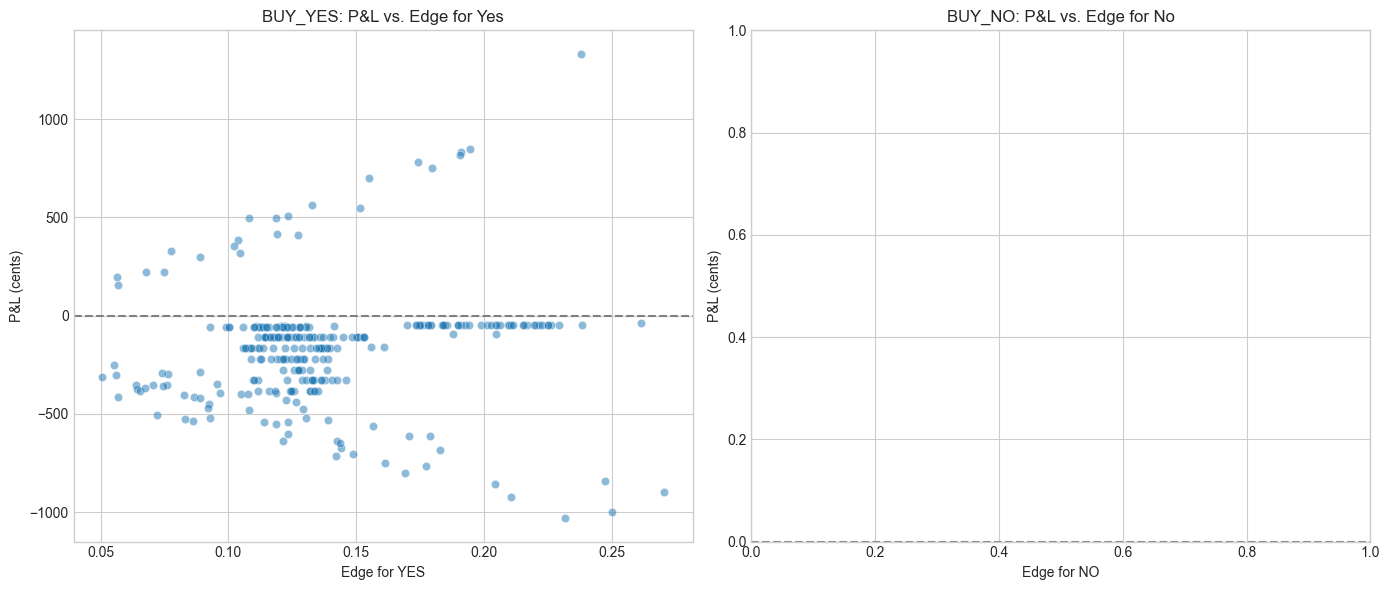

In [22]:
# Cell 4: Analysis of Trade Reasons and Market Conditions

if not df_all_decisions.empty:
    print("\n--- Analysis of Non-Executed Decisions ---")
    # executed_trade_action column in df_all_decisions will have reasons like 'NO_TRADE_THRESHOLD_NOT_MET' etc.
    # from the main trades log.
    # The 'considered_action' from df_eval_details (now merged) is more granular for the initial model output.
    
    if 'considered_action' in df_all_decisions.columns:
        print("\nBreakdown of 'considered_action' (from detailed eval logs):")
        print(df_all_decisions['considered_action'].value_counts(normalize=True) * 100)
    
    print("\nBreakdown of 'executed_trade_action' (final outcome in main log):")
    print(df_all_decisions['executed_trade_action'].value_counts(normalize=True) * 100)


    if not df_executed_trades.empty:
        print("\n--- Analysis of Executed Trades ---")
        # When are trades being made in terms of time_until_market_close_min?
        # This requires 'time_until_market_close_min' to be in your features CSV and loaded into df_all_decisions
        # If it was part of feature_vector_series, it would be a column if your training features CSV included it.
        # For this, we might need to re-extract it or ensure it's in the original CSV.
        # Let's assume 'decision_timestamp_utc' and 'market_close_time_iso' (from merge if needed) are available.
        
        # To get time_until_market_close_min for executed trades, we need market_close_time_iso
        # This would typically come from merging with an outcomes file or being part of the feature set.
        # For simplicity, let's analyze by hour of day for now.
        
        df_executed_trades['hour_of_day'] = df_executed_trades['decision_timestamp_utc'].dt.hour
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df_executed_trades, x='hour_of_day', hue='executed_trade_action')
        plt.title('Number of Executed Trades by Hour of Day (UTC)')
        plt.show()

        # P&L vs. Predicted Probability
        plt.figure(figsize=(12, 6))
        # For BUY_YES trades
        buy_yes_trades = df_executed_trades[df_executed_trades['executed_trade_action'] == 'BUY_YES']
        if not buy_yes_trades.empty:
            sns.scatterplot(data=buy_yes_trades, x='predicted_proba_yes', y='pnl_cents', alpha=0.5, label='BUY_YES')
        
        # For BUY_NO trades (plot against P(NO) = 1 - P(YES) for consistency on x-axis)
        buy_no_trades = df_executed_trades[df_executed_trades['executed_trade_action'] == 'BUY_NO'].copy()
        if not buy_no_trades.empty:
            buy_no_trades['predicted_proba_no'] = 1 - buy_no_trades['predicted_proba_yes']
            # To plot on same P(YES) scale, let's use P(YES) for x-axis for NO trades too.
            # Their PNL is based on P(NO) being correct.
            sns.scatterplot(data=buy_no_trades, x='predicted_proba_yes', y='pnl_cents', alpha=0.5, label='BUY_NO (P(YES) shown)', marker='x')

        plt.title('P&L vs. Model Predicted P(YES) for Executed Trades')
        plt.xlabel('Model Predicted P(YES)')
        plt.ylabel('P&L (cents)')
        plt.axhline(0, color='grey', linestyle='--')
        plt.legend()
        plt.show()

        # If edge columns exist, plot P&L vs Edge
        if edge_cols_exist:
            plt.figure(figsize=(14, 6))
            plt.subplot(1,2,1)
            if not buy_yes_trades.empty:
                sns.scatterplot(data=buy_yes_trades, x='edge_for_yes', y='pnl_cents', alpha=0.5)
            plt.title('BUY_YES: P&L vs. Edge for Yes')
            plt.xlabel('Edge for YES')
            plt.ylabel('P&L (cents)')
            plt.axhline(0, color='grey', linestyle='--')

            plt.subplot(1,2,2)
            if not buy_no_trades.empty:
                 sns.scatterplot(data=buy_no_trades, x='edge_for_no', y='pnl_cents', alpha=0.5)
            plt.title('BUY_NO: P&L vs. Edge for No')
            plt.xlabel('Edge for NO')
            plt.ylabel('P&L (cents)')
            plt.axhline(0, color='grey', linestyle='--')
            plt.tight_layout()
            plt.show()

    else:
        print("No executed trades to analyze for market conditions.")
else:
    print("df_all_decisions is empty. Cannot perform further EDA.")


--- Analysis of 260 Losing Trades ---
Breakdown of Losing Trades by Action:
executed_trade_action
BUY_YES    260
Name: count, dtype: int64

Descriptive Stats for P(YES) in Losing Trades:
count    260.000000
mean       0.675817
std        0.017497
min        0.650000
25%        0.662675
50%        0.674500
75%        0.685125
max        0.792000
Name: predicted_proba_yes, dtype: float64

Descriptive Stats for Edge (YES) in Losing BUY_YES Trades:
count    260.000000
mean       0.137932
std        0.040199
min        0.050400
25%        0.115600
50%        0.128400
75%        0.150525
max        0.270600
Name: edge_for_yes, dtype: float64

Descriptive Stats for Edge (NO) in Losing BUY_NO Trades:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: edge_for_no, dtype: float64


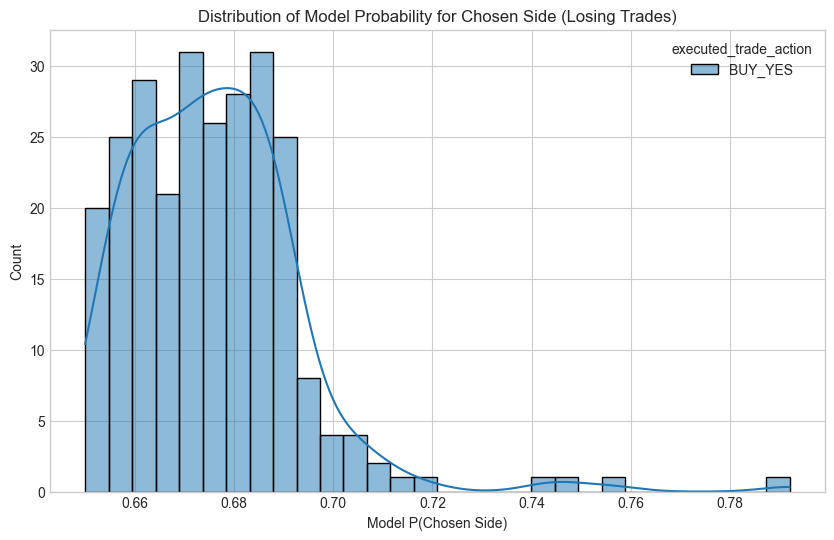


Actual Outcomes for Losing Trades:
actual_market_result    no
executed_trade_action     
BUY_YES                260

Examples of Large Losing Trades (Top 10 by Loss Amount):
        decision_timestamp_utc                market_ticker executed_trade_action  predicted_proba_yes  model_prob_chosen_side  simulated_entry_price_cents actual_market_result  pnl_cents
5662 2025-05-12 12:04:00+00:00  KXBTCD-25MAY1209-T103999.99               BUY_YES               0.6617                  0.6617                         43.0                   no    -1032.0
5674 2025-05-12 12:16:00+00:00  KXBTCD-25MAY1209-T103999.99               BUY_YES               0.6502                  0.6502                         40.0                   no    -1000.0
5663 2025-05-12 12:05:00+00:00  KXBTCD-25MAY1209-T103999.99               BUY_YES               0.6507                  0.6507                         44.0                   no     -924.0
8147 2025-05-12 15:05:00+00:00  KXBTCD-25MAY1212-T102749.99              

In [23]:
# Cell 5: Focus on Losing Trades

if not df_executed_trades.empty:
    df_losing_trades = df_executed_trades[df_executed_trades['pnl_cents'] < 0].copy()
    print(f"\n--- Analysis of {len(df_losing_trades)} Losing Trades ---")

    if not df_losing_trades.empty:
        print("Breakdown of Losing Trades by Action:")
        print(df_losing_trades['executed_trade_action'].value_counts())

        print("\nDescriptive Stats for P(YES) in Losing Trades:")
        print(df_losing_trades['predicted_proba_yes'].describe())
        
        if edge_cols_exist:
            print("\nDescriptive Stats for Edge (YES) in Losing BUY_YES Trades:")
            print(df_losing_trades[df_losing_trades['executed_trade_action']=='BUY_YES']['edge_for_yes'].describe())
            print("\nDescriptive Stats for Edge (NO) in Losing BUY_NO Trades:")
            print(df_losing_trades[df_losing_trades['executed_trade_action']=='BUY_NO']['edge_for_no'].describe())


        # Plot P(chosen side) for losing trades
        df_losing_trades['prob_chosen_side_for_loss'] = df_losing_trades['model_prob_chosen_side']
        
        plt.figure(figsize=(10,6))
        sns.histplot(data=df_losing_trades, x='prob_chosen_side_for_loss', hue='executed_trade_action', bins=30, kde=True)
        plt.title('Distribution of Model Probability for Chosen Side (Losing Trades)')
        plt.xlabel('Model P(Chosen Side)')
        plt.show()
        
        # What was the actual outcome when we lost?
        print("\nActual Outcomes for Losing Trades:")
        print(pd.crosstab(df_losing_trades['executed_trade_action'], df_losing_trades['actual_market_result']))
        
        # Display some examples of large losses
        print("\nExamples of Large Losing Trades (Top 10 by Loss Amount):")
        print(df_losing_trades.sort_values(by='pnl_cents').head(10)[
            ['decision_timestamp_utc', 'market_ticker', 'executed_trade_action', 'predicted_proba_yes', 'model_prob_chosen_side', 'simulated_entry_price_cents', 'actual_market_result', 'pnl_cents']
        ].to_string())

    else:
        print("No losing trades to analyze.")
else:
    print("No executed trades to analyze for losses.")


--- Analysis of P(YES) Buckets (All Decisions) ---

Model P(YES) vs. Empirical P(YES) in Backtest Data:
                  total_decisions  actual_yes_outcomes  empirical_p_yes  \
proba_yes_bucket                                                          
0.00-0.10                       0                    0         0.000000   
0.10-0.20                      26                    0         0.000000   
0.20-0.30                    4077                    0         0.000000   
0.30-0.40                    1836                    3         0.001634   
0.40-0.50                    1006                   52         0.051690   
0.50-0.55                    1042                  117         0.112284   
0.55-0.60                    1590                  367         0.230818   
0.60-0.65                    1357                  365         0.268976   
0.65-0.70                     861                  200         0.232288   
0.70-0.75                     643                  253         0.39346

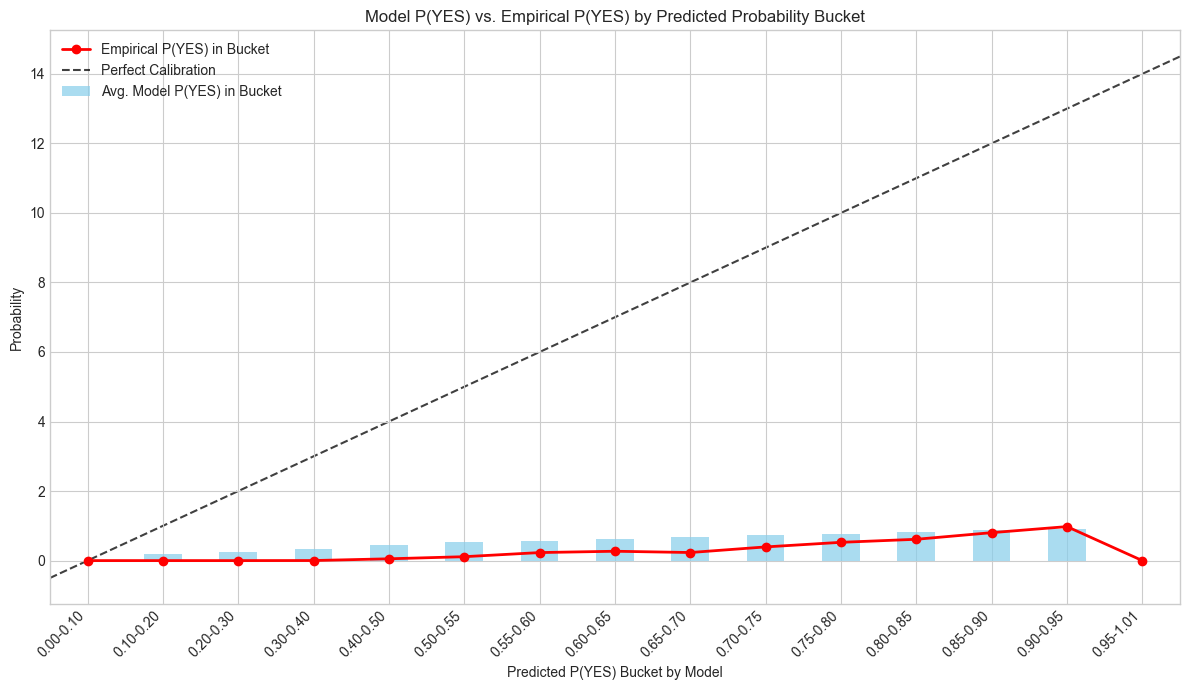


Executed trades occurred in P(YES) range: [0.6500 - 0.7920]
Could not perform actionable range analysis due to unexpected index type for buckets.


In [24]:
# Cell 6: Detailed Analysis of P(YES) Buckets

if not df_all_decisions.empty and 'predicted_proba_yes' in df_all_decisions.columns:
    print("\n--- Analysis of P(YES) Buckets (All Decisions) ---")
    
    bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.70, 0.75, 0.80, 0.85, 0.9, 0.95, 1.01] 
    labels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins)-1)]
    df_all_decisions['proba_yes_bucket'] = pd.cut(df_all_decisions['predicted_proba_yes'], bins=bins, labels=labels, right=False, include_lowest=True)

    bucket_analysis = df_all_decisions.groupby('proba_yes_bucket', observed=False).agg(
        total_decisions=('actual_market_result', 'count'),
        actual_yes_outcomes=('actual_market_result', lambda x: (x == 'yes').sum())
    )
    bucket_analysis['empirical_p_yes'] = bucket_analysis['actual_yes_outcomes'] / bucket_analysis['total_decisions']
    bucket_analysis['avg_predicted_p_yes'] = df_all_decisions.groupby('proba_yes_bucket', observed=False)['predicted_proba_yes'].mean()

    # Handle potential NaN results from division by zero if a bucket has no decisions
    bucket_analysis.fillna(0, inplace=True)

    print("\nModel P(YES) vs. Empirical P(YES) in Backtest Data:")
    print(bucket_analysis)

    plt.figure(figsize=(12, 7))
    ax1 = bucket_analysis['avg_predicted_p_yes'].plot(kind='bar', alpha=0.7, label='Avg. Model P(YES) in Bucket', color='skyblue')
    ax2 = bucket_analysis['empirical_p_yes'].plot(kind='line', marker='o', linewidth=2, label='Empirical P(YES) in Bucket', color='red', secondary_y=False, ax=ax1) # Plot on same y-axis
    
    # Add y=x line for perfect calibration
    lims = [
        np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
        np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
    ]
    ax1.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='Perfect Calibration')


    plt.title('Model P(YES) vs. Empirical P(YES) by Predicted Probability Bucket')
    plt.xlabel('Predicted P(YES) Bucket by Model')
    plt.ylabel('Probability')
    plt.xticks(rotation=45, ha='right')
    ax1.legend(loc='upper left')
    # ax2.legend(loc='upper right') # Not needed if plotted on same axis
    plt.tight_layout()
    plt.show()

    if not df_executed_trades.empty and 'predicted_proba_yes' in df_executed_trades.columns:
        actionable_min_prob = df_executed_trades['predicted_proba_yes'].min()
        actionable_max_prob = df_executed_trades['predicted_proba_yes'].max()
        print(f"\nExecuted trades occurred in P(YES) range: [{actionable_min_prob:.4f} - {actionable_max_prob:.4f}]")
        
        # Filter buckets based on the range of executed trades
        # Accessing CategoricalIndex interval properties
        if isinstance(bucket_analysis.index, pd.CategoricalIndex) and isinstance(bucket_analysis.index.categories, pd.IntervalIndex):
            actionable_bucket_data = bucket_analysis[
                (bucket_analysis.index.categories.left >= actionable_min_prob*0.95) & 
                (bucket_analysis.index.categories.right <= actionable_max_prob*1.05)
            ]
            if not actionable_bucket_data.empty:
                print("\nCalibration in Actionable Range (approximate):")
                print(actionable_bucket_data)
            else:
                print(f"No buckets fully within the approximate actionable range based on current binning.")
        else:
            print("Could not perform actionable range analysis due to unexpected index type for buckets.")
            
else:
    print("df_all_decisions is empty or 'predicted_proba_yes' column is missing for bucket analysis.")


--- Losing BUY_YES Trades (260) ---
Losing BUY_YES - P(YES) stats:
count    260.000000
mean       0.675817
std        0.017497
min        0.650000
25%        0.662675
50%        0.674500
75%        0.685125
max        0.792000
Name: predicted_proba_yes, dtype: float64
Losing BUY_YES - Edge for YES stats:
count    260.000000
mean       0.137932
std        0.040199
min        0.050400
25%        0.115600
50%        0.128400
75%        0.150525
max        0.270600
Name: edge_for_yes, dtype: float64


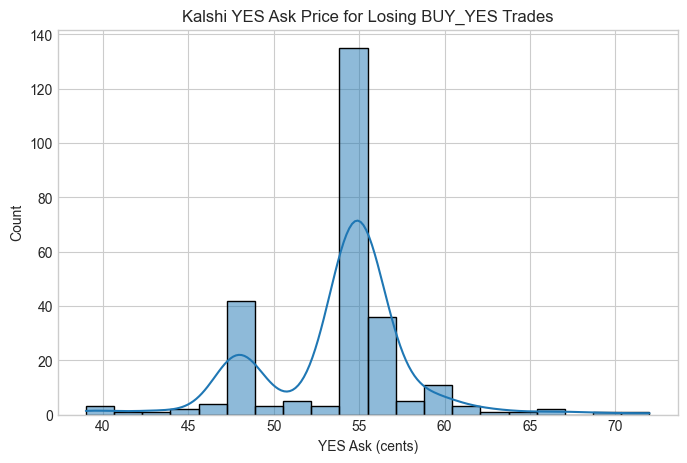


--- Winning BUY_YES Trades (23) ---
Winning BUY_YES - P(YES) stats:
count    23.000000
mean      0.684626
std       0.035793
min       0.651400
25%       0.660650
50%       0.668700
75%       0.699650
max       0.784400
Name: predicted_proba_yes, dtype: float64
Winning BUY_YES - Edge for YES stats:
count    23.000000
mean      0.127670
std       0.049385
min       0.056400
25%       0.095600
50%       0.119100
75%       0.164650
max       0.237900
Name: edge_for_yes, dtype: float64


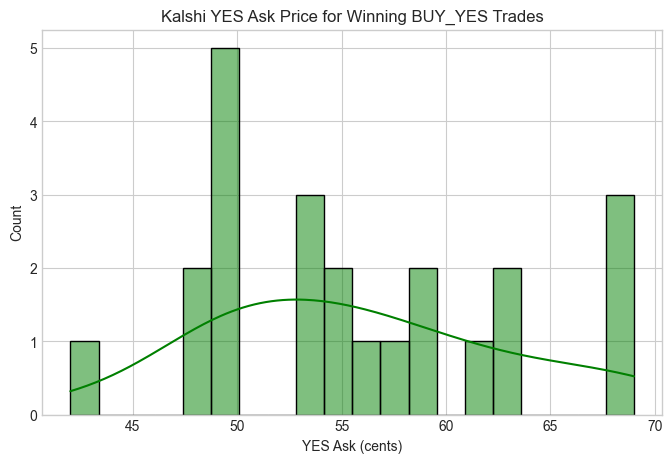


--- Decisions where model predicted P(YES) > 0.6 (19495) ---
Actual outcomes when model was confident YES (by P(YES) bucket):
actual_market_result   no   yes
proba_yes_bucket               
0.00-0.10               0     0
0.10-0.20               0     0
0.20-0.30               0     0
0.30-0.40               0     0
0.40-0.50               0     0
0.50-0.55               0     0
0.55-0.60               0     0
0.60-0.65             991   364
0.65-0.70             661   200
0.70-0.75             390   253
0.75-0.80             369   409
0.80-0.85             558   884
0.85-0.90             996  4074
0.90-0.95             208  9138
0.95-1.01               0     0


In [25]:
# Cell 7: Feature Analysis for Specific Trade Outcomes

if not df_all_decisions.empty and not df_executed_trades.empty:
    # --- Compare features of Losing BUY_YES vs. Winning BUY_YES (if any) ---
    losing_buy_yes = df_executed_trades[(df_executed_trades['executed_trade_action'] == 'BUY_YES') & (df_executed_trades['pnl_cents'] < 0)]
    winning_buy_yes = df_executed_trades[(df_executed_trades['executed_trade_action'] == 'BUY_YES') & (df_executed_trades['pnl_cents'] > 0)]

    if not losing_buy_yes.empty:
        print(f"\n--- Losing BUY_YES Trades ({len(losing_buy_yes)}) ---")
        print("Losing BUY_YES - P(YES) stats:")
        print(losing_buy_yes['predicted_proba_yes'].describe())
        if 'edge_for_yes' in losing_buy_yes.columns:
            print("Losing BUY_YES - Edge for YES stats:")
            print(losing_buy_yes['edge_for_yes'].describe())
            
        if 'kalshi_yes_ask_at_decision_t' in losing_buy_yes.columns:
            plt.figure(figsize=(8,5))
            sns.histplot(losing_buy_yes['kalshi_yes_ask_at_decision_t'].dropna(), bins=20, kde=True)
            plt.title('Kalshi YES Ask Price for Losing BUY_YES Trades')
            plt.xlabel('YES Ask (cents)')
            plt.show()

    if not winning_buy_yes.empty:
        print(f"\n--- Winning BUY_YES Trades ({len(winning_buy_yes)}) ---")
        print("Winning BUY_YES - P(YES) stats:")
        print(winning_buy_yes['predicted_proba_yes'].describe())
        if 'edge_for_yes' in winning_buy_yes.columns:
            print("Winning BUY_YES - Edge for YES stats:")
            print(winning_buy_yes['edge_for_yes'].describe())
            
        if 'kalshi_yes_ask_at_decision_t' in winning_buy_yes.columns:
            plt.figure(figsize=(8,5))
            sns.histplot(winning_buy_yes['kalshi_yes_ask_at_decision_t'].dropna(), bins=20, kde=True, color='green')
            plt.title('Kalshi YES Ask Price for Winning BUY_YES Trades')
            plt.xlabel('YES Ask (cents)')
            plt.show()
    else:
        print("\nNo winning BUY_YES trades found in this backtest period.")
        
    # --- Compare high P(YES) predictions that resolved YES vs. NO ---
    # Use the variable defined in Cell 1
    high_conf_yes_preds = df_all_decisions[df_all_decisions['predicted_proba_yes'] > STRATEGY_MIN_MODEL_PROB_FOR_CONSIDERATION].copy()
    
    if not high_conf_yes_preds.empty:
        print(f"\n--- Decisions where model predicted P(YES) > {STRATEGY_MIN_MODEL_PROB_FOR_CONSIDERATION} ({len(high_conf_yes_preds)}) ---")
        
        # Ensure 'proba_yes_bucket' is available for crosstab
        if 'proba_yes_bucket' not in high_conf_yes_preds.columns and 'predicted_proba_yes' in high_conf_yes_preds.columns:
            # Re-apply binning if needed (bins/labels should be defined from Cell 6 or redefined here)
            bins_cell7 = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.70, 0.75, 0.80, 0.85, 0.9, 0.95, 1.01] 
            labels_cell7 = [f"{bins_cell7[i]:.2f}-{bins_cell7[i+1]:.2f}" for i in range(len(bins_cell7)-1)]
            high_conf_yes_preds['proba_yes_bucket'] = pd.cut(high_conf_yes_preds['predicted_proba_yes'], bins=bins_cell7, labels=labels_cell7, right=False, include_lowest=True)


        if 'proba_yes_bucket' in high_conf_yes_preds.columns:
            actual_outcomes_for_high_conf_yes = pd.crosstab(high_conf_yes_preds['proba_yes_bucket'], high_conf_yes_preds['actual_market_result'], dropna=False)
            print("Actual outcomes when model was confident YES (by P(YES) bucket):")
            print(actual_outcomes_for_high_conf_yes)
        else:
            print("Cannot create crosstab: 'proba_yes_bucket' missing from high_conf_yes_preds.")
            
    else:
        print(f"No decisions found where model predicted P(YES) > {STRATEGY_MIN_MODEL_PROB_FOR_CONSIDERATION}")

else:
    print("df_all_decisions or df_executed_trades is empty for detailed feature analysis.")